In [1]:
# !pip install comet-ml

In [2]:
# !pip install shap

# Imports

In [4]:
# Import before anyone else

from comet_ml import Experiment

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score, roc_curve, auc, classification_report
from sklearn.calibration import calibration_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, classification_report




import shap


import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pickle

from collections import Counter

In [6]:
import sys
# sys.path.append('../ift6758/data/')
sys.path.append('../ift6758/visualizations/')

from question_5_plots import *

In [2]:
question_no = 5

# Load Data

In [7]:
df = pd.read_csv(r'final_df.csv', index_col = None)
print(df.columns)


Index(['Unnamed: 0', 'game_id', 'season', 'season_type', 'event_id',
       'home_team', 'away_team', 'home_team_side_1st_period', 'attacking_team',
       'attacking_player',
       ...
       'attacking_team_Philadelphia Flyers',
       'attacking_team_Pittsburgh Penguins', 'attacking_team_San Jose Sharks',
       'attacking_team_St. Louis Blues', 'attacking_team_Tampa Bay Lightning',
       'attacking_team_Toronto Maple Leafs',
       'attacking_team_Vancouver Canucks',
       'attacking_team_Vegas Golden Knights',
       'attacking_team_Washington Capitals', 'attacking_team_Winnipeg Jets'],
      dtype='object', length=249)


In [8]:
df.drop(columns = ['Unnamed: 0'], inplace = True)

#### Features from Part 4

In [32]:
shot_type_feat = [x for x in df.columns if "shot_type_" in x]
len(shot_type_feat)

7

In [35]:
new_feat = ["game_seconds", "period", 'x_coordinates','y_coordinates', 'shot_type', 'distance_from_net', 'angle_from_net',
               "previous_event_type", 'previous_event_x_coordinates', 'previous_event_y_coordinates',
              'time_since_last_event', 'distance_from_last_event', 'rebound', 'change_in_angle', 'speed',
              'time_since_powerplay_started', '5v5','4v4','3v3','5v4','5v3','4v3','4v5','3v5','3v4']
new_feat.extend(shot_type_feat)

In [36]:
new_feat

['game_seconds',
 'period',
 'x_coordinates',
 'y_coordinates',
 'shot_type',
 'distance_from_net',
 'angle_from_net',
 'previous_event_type',
 'previous_event_x_coordinates',
 'previous_event_y_coordinates',
 'time_since_last_event',
 'distance_from_last_event',
 'rebound',
 'change_in_angle',
 'speed',
 'time_since_powerplay_started',
 '5v5',
 '4v4',
 '3v3',
 '5v4',
 '5v3',
 '4v3',
 '4v5',
 '3v5',
 '3v4',
 'shot_type_Backhand',
 'shot_type_Deflected',
 'shot_type_Slap Shot',
 'shot_type_Snap Shot',
 'shot_type_Tip-In',
 'shot_type_Wrap-around',
 'shot_type_Wrist Shot']

# Data Split

In [27]:
df_train = df[df['season'] != 20192020]
df_train = df_train[df_train['season_type'] == 'R']
df_test = df[df['season'] == 20192020]

## 5.1 Train-Valid

In [28]:
X_1 = df_train[['angle_from_net', 'distance_from_net']]
y_1 = df_train['goal_ind']
#y = y.astype(int)
# (#BLOG)
X_train_1, X_valid_1, y_train_1, y_valid_1 = train_test_split(X_1,y_1,test_size=0.15,random_state=10, stratify=y_1, shuffle = True)

## 5.2 Train-Valid

In [37]:
obj_features = df_train[new_feat].select_dtypes('object').columns
obj_features

Index(['shot_type', 'previous_event_type'], dtype='object')

In [38]:
def preprocess(df):
    df.drop(columns = ['shot_type'], inplace = True)
    #convert string values to numerical values
    le = LabelEncoder()
    df["previous_event_type"] = le.fit_transform(df["previous_event_type"])
    
    return df

In [39]:
X_2 = df_train[new_feat]
y_2 = df_train['goal_ind']

X_2 = preprocess(X_2)

print(X_2.columns)
#y = y.astype(int)
X_train_2, X_valid_2, y_train_2, y_valid_2 = train_test_split(X_2,y_2,test_size=0.15,random_state=10, stratify=y_2, shuffle = True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Index(['game_seconds', 'period', 'x_coordinates', 'y_coordinates',
       'distance_from_net', 'angle_from_net', 'previous_event_type',
       'previous_event_x_coordinates', 'previous_event_y_coordinates',
       'time_since_last_event', 'distance_from_last_event', 'rebound',
       'change_in_angle', 'speed', 'time_since_powerplay_started', '5v5',
       '4v4', '3v3', '5v4', '5v3', '4v3', '4v5', '3v5', '3v4',
       'shot_type_Backhand', 'shot_type_Deflected', 'shot_type_Slap Shot',
       'shot_type_Snap Shot', 'shot_type_Tip-In', 'shot_type_Wrap-around',
       'shot_type_Wrist Shot'],
      dtype='object')


# XGBoost Classifier

## 5.1 Baseline XGBoost Model

Train/Validation Setup:
We choose to 'stratify' over the target class variable, due to the high imbalance in it.
It is always desirable to split the dataset into train and validation sets in a way that preserves the same proportions of datapoints in each class as in the original complete dataset. This is important in order for the model to see fair number of examples from both the classes(0,1 in this case) during training.
Shuffle is used to prevent data from having all similar samples together, which can harm generalization capacity later.

### Create Experiment

In [41]:
X_train_2.shape

(264423, 31)

In [107]:
experiment_1 = Experiment(api_key = "Pvo648g2gS8jvAP6ZVdt45H5A", project_name = "milestone-2", workspace="kleitoun")

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in '/kaggle/working' nor in any parent directory. You can override where Comet is looking for a Git Patch by setting the configuration `COMET_GIT_DIRECTORY`
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/kleitoun/milestone-2/b2e8d79ab6fe40cb8dfef23d74c070b8



In [43]:
experiment_1 = Experiment(api_key = "Pvo648g2gS8jvAP6ZVdt45H5A", project_name = "milestone-2", workspace="kleitoun")

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/kleitoun/milestone-2/6a7c8a2bf03243ec9311afe5263a4646



### Baseline Model Training

In [108]:
model_1 = XGBClassifier()
 
# fit the model with the training data
model_1.fit(X_train_1,y_train_1)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=2,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [109]:
preds_1 = model_1.predict(X_valid_1)

### Visualize Feature Importance with SHAP

In [110]:
plot_X_train_1 = X_train_1.rename(columns = {"angle_from_net": "Shot Angle", "distance_from_net": "Shot Distance"})

In [111]:
explainer = shap.Explainer(model_1)
shap_values = explainer(plot_X_train_1)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


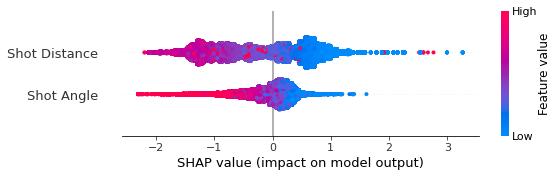

In [112]:
shap.summary_plot(shap_values, X_train_1)

### Evaluation - XGBoost Baseline (5.1)

In [1]:
# load model file, if pretrained

# model_1 = pickle.load(open("XGBoost_Baseline_model.pickle", 'rb'))


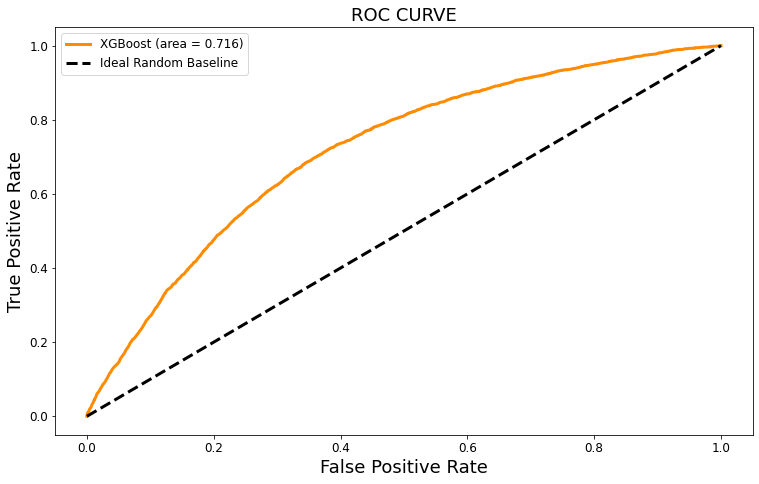

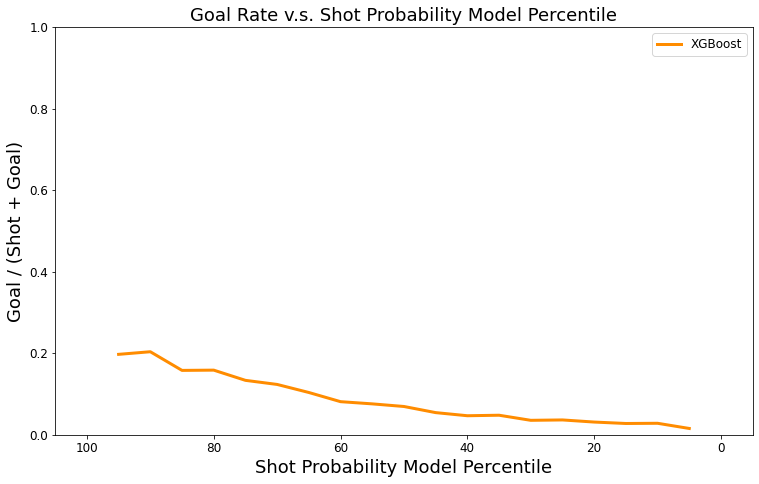

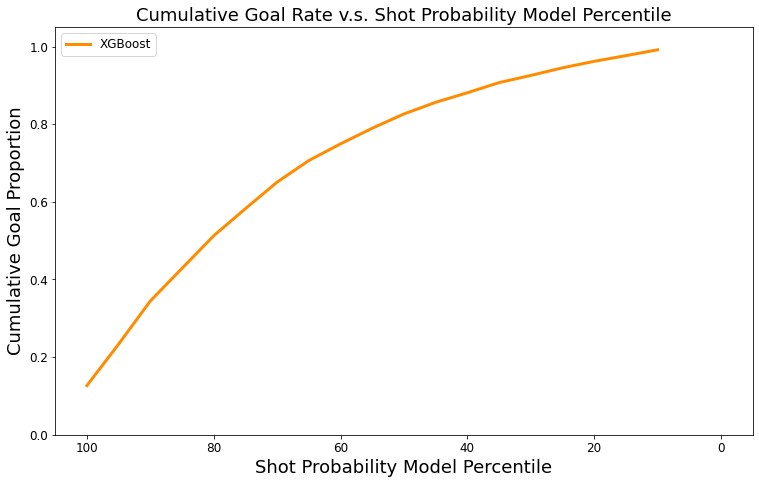

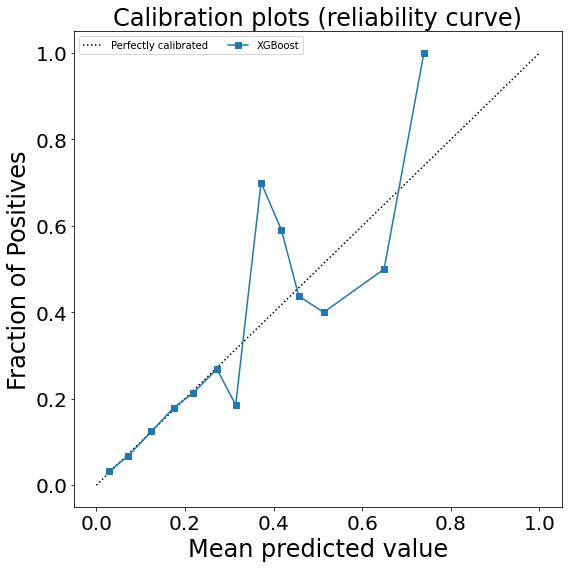

In [166]:
#### USAGE ####
model_name_1 = '_XGBoost_Baseline'

perf_eval = Performance_Eval(model_1,model_name_1, X_train_1, y_train_1, X_valid_1, y_valid_1, question_no = question_no)
roc = perf_eval.get_roc_auc_plot()
grp = perf_eval.get_goal_rate_plot()
crp = perf_eval.get_cum_rate_plot()
cp = perf_eval.get_calibration_plot()

In [117]:
# experiment_1.log_image("Q5_ROC.Curve.png")
# experiment_1.log_image("Q5_Goal_Rate.png")
# experiment_1.log_image("Q5_Cum_Goal.png")
# experiment_1.log_image("Q5_Calibration_Curve.png")

{'web': 'https://www.comet.ml/api/image/download?imageId=44febefdd3a144c4abdc4ba8d177a7d2&experimentKey=b2e8d79ab6fe40cb8dfef23d74c070b8',
 'api': 'https://www.comet.ml/api/rest/v1/image/get-image?imageId=44febefdd3a144c4abdc4ba8d177a7d2&experimentKey=b2e8d79ab6fe40cb8dfef23d74c070b8',
 'imageId': '44febefdd3a144c4abdc4ba8d177a7d2'}

## Log Metrics, Model and Plots

In [ ]:
experiment_1.log_figure(figure = roc, figure_name=f'Q{question_no}_{model_name_1}_ROC_curve.png')
experiment_1.log_figure(figure = roc, figure_name=f'Q{question_no}_{model_name_1}_Goal_Rate.png')
experiment_1.log_figure(figure = roc, figure_name=f'Q{question_no}_{model_name_1}_Cum_Goal.png')
experiment_1.log_figure(figure = roc, figure_name=f'Q{question_no}_{model_name_1}_Calibration_Curve.png')


In [114]:
y_pred_proba_1 = model_1.predict_proba(X_valid_1)[:,1]
roc_auc =  roc_auc_score(y_valid_1,y_pred_proba_1)
y_pred_1 = model_1.predict(X_valid_1)
accuracy =  accuracy_score(y_valid_1, y_pred_1)
report = classification_report(y_valid_1, y_pred_1, output_dict=True)

print(roc_auc, accuracy)
report
#result: 0.7163373991488216 0.9062212030945288

0.7163373991488216 0.9062212030945288


{'0': {'precision': 0.9063605376551547,
  'recall': 0.99981081656301,
  'f1-score': 0.9507949715519375,
  'support': 42287},
 '1': {'precision': 0.5,
  'recall': 0.0018281535648994515,
  'f1-score': 0.003642987249544627,
  'support': 4376},
 'accuracy': 0.9062212030945288,
 'macro avg': {'precision': 0.7031802688275773,
  'recall': 0.5008194850639547,
  'f1-score': 0.47721897940074104,
  'support': 46663},
 'weighted avg': {'precision': 0.8682525353239938,
  'recall': 0.9062212030945288,
  'f1-score': 0.8619721979774294,
  'support': 46663}}

In [115]:
metrics = {
    "roc_auc": roc_auc,
    "accuracy": accuracy,
    "classification report": report
}

In [116]:
experiment_1.log_metrics(metrics)

COMET WARNING: Cannot safely convert {'0': {'precision': 0.9063605376551547, 'recall': 0.99981081656301, 'f1-score': 0.9507949715519375, 'support': 42287}, '1': {'precision': 0.5, 'recall': 0.0018281535648994515, 'f1-score': 0.003642987249544627, 'support': 4376}, 'accuracy': 0.9062212030945288, 'macro avg': {'precision': 0.7031802688275773, 'recall': 0.5008194850639547, 'f1-score': 0.47721897940074104, 'support': 46663}, 'weighted avg': {'precision': 0.8682525353239938, 'recall': 0.9062212030945288, 'f1-score': 0.8619721979774294, 'support': 46663}} object to a scalar value, using its string representation for logging.


In [119]:
pickle.dump(model_1, open("XGBoost_Baseline_model.pickle", 'wb'))
t = pickle.load(open("XGBoost_Baseline_model.pickle", 'rb'))

experiment_1.log_model(name = "XGBoost_Baseline_model", file_or_folder = "XGBoost_Baseline_model.pickle")

{'web': 'https://www.comet.ml/api/asset/download?assetId=1c256a14709c45f2b5969baf9319a83a&experimentKey=b2e8d79ab6fe40cb8dfef23d74c070b8',
 'api': 'https://www.comet.ml/api/rest/v2/experiment/asset/get-asset?assetId=1c256a14709c45f2b5969baf9319a83a&experimentKey=b2e8d79ab6fe40cb8dfef23d74c070b8',
 'assetId': '1c256a14709c45f2b5969baf9319a83a'}

In [118]:
experiment_1.end

<bound method BaseExperiment.end of <comet_ml.Experiment object at 0x7f27a044f550>>

In [120]:
experiment_1.url
#'https://www.comet.ml/kleitoun/milestone-2/b2e8d79ab6fe40cb8dfef23d74c070b8'

'https://www.comet.ml/kleitoun/milestone-2/b2e8d79ab6fe40cb8dfef23d74c070b8'

## 5.2

### Create Experiment

In [15]:
experiment_2 = Experiment(api_key = "Pvo648g2gS8jvAP6ZVdt45H5A", 
                        project_name = "milestone-2", 
                        workspace="kleitoun")

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in '/kaggle/working' nor in any parent directory. You can override where Comet is looking for a Git Patch by setting the configuration `COMET_GIT_DIRECTORY`
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/kleitoun/milestone-2/e5a992ce9cbb4708928220e6f73f9263



### Remove NaNs and Infs

In [16]:
def impute_df(df):
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.fillna(0, inplace=True)
    return df

In [17]:
X_train_2 = impute_df(X_train_2)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### Train a vanilla XGBoost Classifier

In [18]:
########## WITH ONLY Q4 features
model_2 = XGBClassifier()
 
# fit the model with the training data
model_2.fit(X_train_2,y_train_2)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=2,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [19]:
preds_2 = model_2.predict(X_valid_2)

In [24]:
y_pred_proba_2 = model_2.predict_proba(X_valid_2)[:,1]
roc_auc =  roc_auc_score(y_valid_2,y_pred_proba_2)
y_pred_2 = model_2.predict(X_valid_2)
accuracy =  accuracy_score(y_valid_2, y_pred_2)
report = classification_report(y_valid_2, y_pred_2, output_dict=True)

print(roc_auc, accuracy)

# result: 0.7653420509819099 0.9046782247176564

0.7653420509819099 0.9046782247176564


# Hyper-paramter Tuning

In [23]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold

In [ ]:
# A parameter grid for XGBoost
params = {
    'n_estimators': [150, 300,500],
    'learning_rate': [0.3, 0.2, 0.1],
    'max_depth': list(range(16,30,2))
}

In [ ]:
# %%time
# folds = 3
# param_comb = 5

# skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)
# # random search is said to be faster and more efficient at times
# random_search = RandomizedSearchCV(model_2, param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=4, cv=skf.split(X_train_2,y_train_2), verbose=3, random_state=1001 )
# # random_search = GridSearchCV(model_2, params, scoring='roc_auc', n_jobs=4, cv=skf.split(X_train_2,y_train_2), verbose=3)


# random_search.fit(X_train_2,y_train_2)

# hp_params = random_search.best_params_


In [25]:
hp_params = {'n_estimators': 150,
    'learning_rate': 0.3,
    'max_depth': 18}
model_2_hmtuned = XGBClassifier(**hp_params)
model_2_hmtuned.fit(X_train_2, y_train_2)

model_2_hmtuned = random_search.best_estimator_


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.3, max_delta_step=0,
              max_depth=18, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=150, n_jobs=2,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [26]:
y_pred_proba_2 = model_2_hmtuned.predict_proba(X_valid_2)[:,1]
roc_auc =  roc_auc_score(y_valid_2,y_pred_proba_2)
y_pred_2 = model_2_hmtuned.predict(X_valid_2)
accuracy =  accuracy_score(y_valid_2, y_pred_2)
report = classification_report(y_valid_2, y_pred_2, output_dict=True)

print(roc_auc, accuracy)

# result: 0.7265493652260179 0.9025994899599254

0.7265493652260179 0.9025994899599254


In [51]:
# experiment_2.log_parameters(hp_params)

## Visualize Hyperparameter Tuning Importance

#### Visualizing a few combinations, for example

In [139]:
param_list = [{'n_estimators': 150,
    'learning_rate': 0.3,
    'max_depth': 18, 'gamma': 2},
              {'n_estimators': 300,
    'learning_rate': 0.1,
    'max_depth': 30, 'gamma': 2},
              {'n_estimators': 150,
    'learning_rate': 0.3,
    'max_depth': 18}, 
             {'n_estimators': 300,
    'learning_rate': 0.1,
    'max_depth': 30, 'gamma': 2, 'min_child_weight': 0.25}]

In [140]:
# names = ['parameter set 1', 'parameter set 2', 'parameter set 3']
classifiers = [XGBClassifier(**param_list[0]),
               XGBClassifier(**param_list[1]),
               XGBClassifier(**param_list[2]),
               XGBClassifier(**param_list[3])
               ]

m1 = classifiers[0].fit(X_train_2, y_train_2)
m2 = classifiers[1].fit(X_train_2, y_train_2)
m3 = classifiers[2].fit(X_train_2, y_train_2)
m4 = classifiers[3].fit(X_train_2, y_train_2)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html


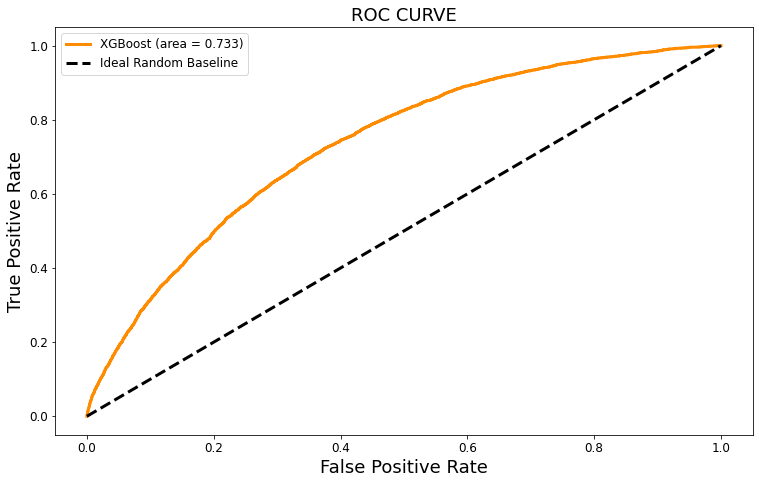

In [127]:
model_name_2 = "2_xgboost_set_1"
perf_eval = Performance_Eval(m1, model_name_2, X_train_2, y_train_2, X_valid_2, y_valid_2,question_no = question_no)
roc_set_1 = perf_eval.get_roc_auc_plot()

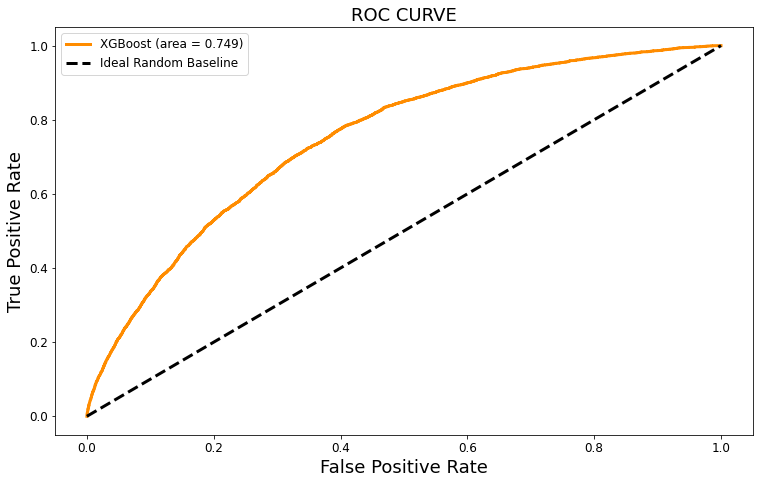

In [136]:
model_name_3 = "2_xgboost_set_2"
perf_eval = Performance_Eval(m2, model_name_3, X_train_2, y_train_2, X_valid_2, y_valid_2,question_no = question_no)
roc_set_2 = perf_eval.get_roc_auc_plot()

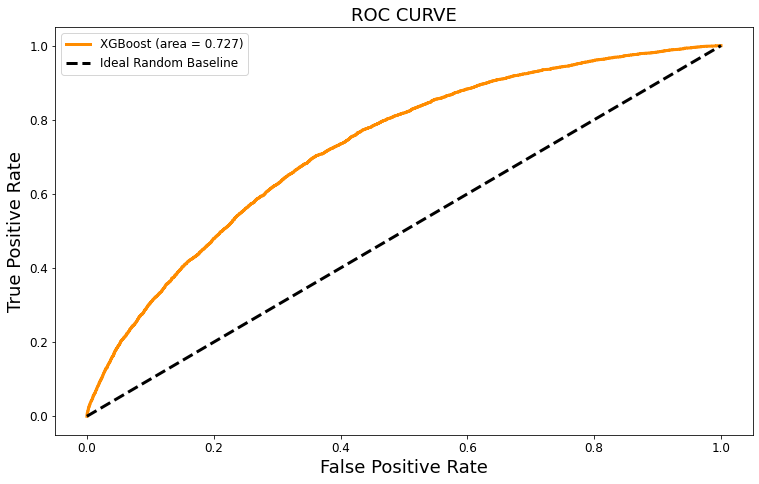

In [129]:
model_name_4 = "2_xgboost_set_3"
perf_eval = Performance_Eval(m3,model_name_4, X_train_2, y_train_2, X_valid_2, y_valid_2,question_no = question_no)
roc_set_3 = perf_eval.get_roc_auc_plot()

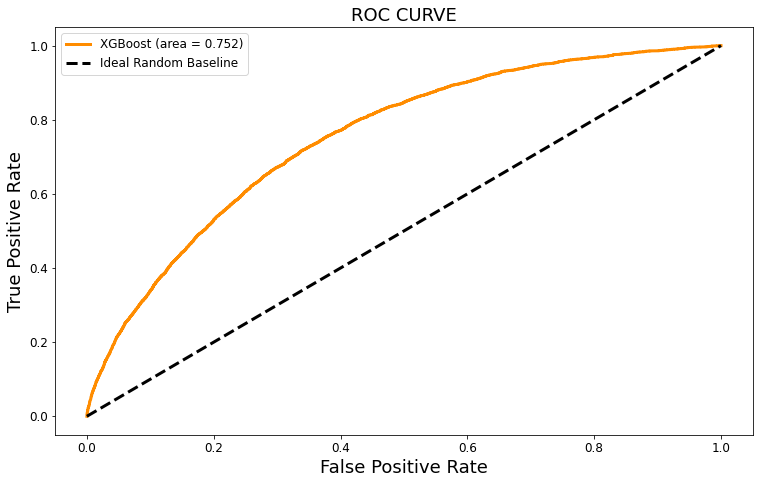

In [141]:
model_name_5 = "2_xgboost_set_4"
perf_eval = Performance_Eval(m4,model_name_5, X_train_2, y_train_2, X_valid_2, y_valid_2,question_no = question_no)
roc_set_4 =  perf_eval.get_roc_auc_plot()

In [ ]:
step = "hmtuning"
experiment_2.log_figure(figure = roc_set_1, figure_name=f'Q{question_no}_{step}_ROC_curve_set_1.png')
experiment_2.log_figure(figure = roc_set_2, figure_name=f'Q{question_no}_{step}_ROC_curve_set_2.png')
experiment_2.log_figure(figure = roc_set_3, figure_name=f'Q{question_no}_{step}_ROC_curve_set_3.png')
experiment_2.log_figure(figure = roc_set_4, figure_name=f'Q{question_no}_{step}_ROC_curve_set_4.png')

#### Result: param_list[3] turns out the most effective

# To avoid heavy class imbalance problem, tuning class weights scale

### Class weights

In [36]:
from sklearn.utils import class_weight

# assigining class weight to balanced does NOT yield any good results/makes NO difference (#BLOG)

classes_weights = class_weight.compute_sample_weight(
    # based on ratio of train set class distribution
    class_weight={0:0.10, 1:0.90},
    y=y_train_2
)

In [143]:
model_2_cw = XGBClassifier(**param_list[3])

model_2_cw.fit(X_train_2, y_train_2, sample_weight=classes_weights)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=2, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=30, min_child_weight=0.25, missing=nan,
              monotone_constraints='()', n_estimators=300, n_jobs=2,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [144]:
y_pred_cw = model_2_cw.predict(X_valid_2)


### Evaluation - XGBoost post Class Weights (5.2)

In [145]:
y_pred_proba_cw = model_2_cw.predict_proba(X_valid_2)[:,1]
roc_auc =  roc_auc_score(y_valid_2,y_pred_proba_cw)
y_pred_cw = model_2_cw.predict(X_valid_2)
accuracy =  accuracy_score(y_valid_2, y_pred_cw)
report = classification_report(y_valid_2, y_pred_cw, output_dict=True)

print(roc_auc, accuracy)
report

#result: 0.7605648908916087 0.7943124102608062

0.7605648908916087 0.7943124102608062


{'0': {'precision': 0.941755182572502,
  'recall': 0.8239884598103436,
  'f1-score': 0.8789445803798905,
  'support': 42287},
 '1': {'precision': 0.22982201986754966,
  'recall': 0.5075411334552102,
  'f1-score': 0.31638176638176635,
  'support': 4376},
 'accuracy': 0.7943124102608062,
 'macro avg': {'precision': 0.5857886012200259,
  'recall': 0.6657647966327769,
  'f1-score': 0.5976631733808284,
  'support': 46663},
 'weighted avg': {'precision': 0.8749909470969246,
  'recall': 0.7943124102608062,
  'f1-score': 0.8261881164993902,
  'support': 46663}}

In [146]:
metrics = {
    "roc_auc": roc_auc,
    "accuracy": accuracy,
    "classification report": report
}

In [147]:
experiment_2.log_metrics(metrics)

COMET WARNING: Cannot safely convert {'0': {'precision': 0.941755182572502, 'recall': 0.8239884598103436, 'f1-score': 0.8789445803798905, 'support': 42287}, '1': {'precision': 0.22982201986754966, 'recall': 0.5075411334552102, 'f1-score': 0.31638176638176635, 'support': 4376}, 'accuracy': 0.7943124102608062, 'macro avg': {'precision': 0.5857886012200259, 'recall': 0.6657647966327769, 'f1-score': 0.5976631733808284, 'support': 46663}, 'weighted avg': {'precision': 0.8749909470969246, 'recall': 0.7943124102608062, 'f1-score': 0.8261881164993902, 'support': 46663}} object to a scalar value, using its string representation for logging.


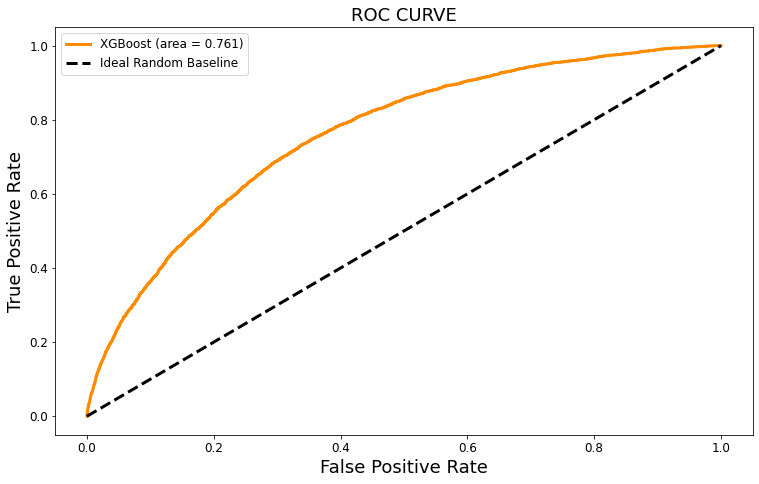

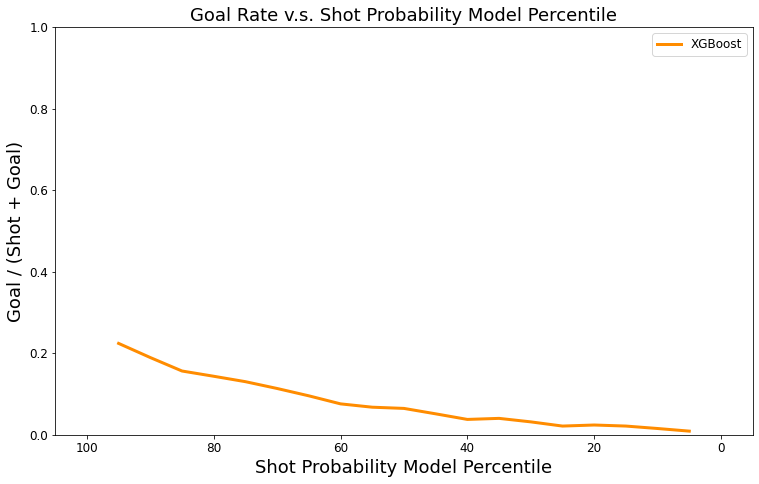

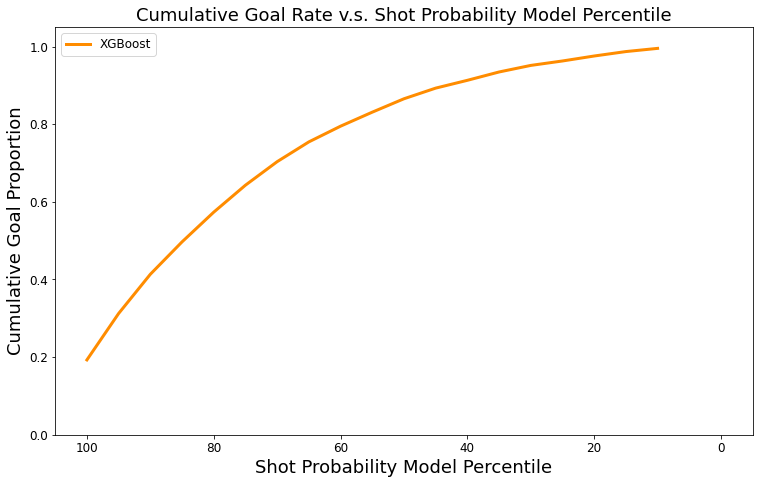

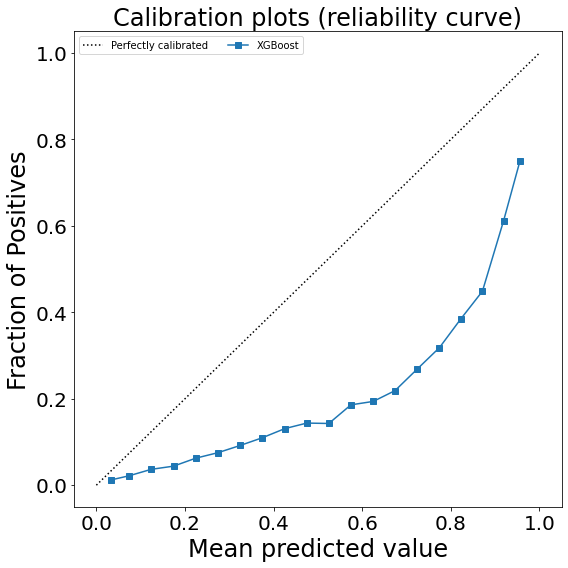

In [165]:
#### USAGE ####
model_name_6 = '2_xgboost_hmtuning'
perf_eval = Performance_Eval(model_2_cw, model_name_6, X_train_2, y_train_2, X_valid_2, y_valid_2, question_no = question_no)
roc = perf_eval.get_roc_auc_plot()
grp = perf_eval.get_goal_rate_plot()
crp = perf_eval.get_cum_rate_plot()
cr = perf_eval.get_calibration_plot()

### Log Model and Plots

In [149]:
experiment_2.log_figure(figure = roc, figure_name=f'Q{question_no}_{model_name}_ROC_curve.png')
experiment_2.log_figure(figure = grp, figure_name=f'Q{question_no}_{model_name}_Goal_Rate.png')
experiment_2.log_figure(figure = crp, figure_name=f'Q{question_no}_{model_name}_Cum_Goal.png')
experiment_2.log_figure(figure = cr, figure_name=f'Q{question_no}_{model_name}_Calibration_Curve.png')


{'web': 'https://www.comet.ml/api/image/download?imageId=973c26b775a14d85ab64c3bf4e97a2c4&experimentKey=e5a992ce9cbb4708928220e6f73f9263',
 'api': 'https://www.comet.ml/api/rest/v1/image/get-image?imageId=973c26b775a14d85ab64c3bf4e97a2c4&experimentKey=e5a992ce9cbb4708928220e6f73f9263',
 'imageId': '973c26b775a14d85ab64c3bf4e97a2c4'}

In [150]:
pickle.dump(model_2_cw, open("XGBoost_hmtuning_model_v2.pickle", 'wb'))
t = pickle.load(open("XGBoost_hmtuning_model_v2.pickle", 'rb'))

experiment_2.log_model(name = "XGBoost_hmtuning_model_v2", file_or_folder = "XGBoost_hmtuning_model_v2.pickle")

{'web': 'https://www.comet.ml/api/asset/download?assetId=1de1157ce67f4ee0957bcd79a9dc9723&experimentKey=e5a992ce9cbb4708928220e6f73f9263',
 'api': 'https://www.comet.ml/api/rest/v2/experiment/asset/get-asset?assetId=1de1157ce67f4ee0957bcd79a9dc9723&experimentKey=e5a992ce9cbb4708928220e6f73f9263',
 'assetId': '1de1157ce67f4ee0957bcd79a9dc9723'}

In [57]:
experiment_2.end

<bound method BaseExperiment.end of <comet_ml.Experiment object at 0x7f283ba71a10>>

In [151]:
experiment_2.url

'https://www.comet.ml/kleitoun/milestone-2/e5a992ce9cbb4708928220e6f73f9263'

# Feature Selection (5.3)

### Create Experiment

In [60]:
experiment_3 = Experiment(api_key = "Pvo648g2gS8jvAP6ZVdt45H5A", 
                        project_name = "milestone-2", 
                        workspace="kleitoun")

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in '/kaggle/working' nor in any parent directory. You can override where Comet is looking for a Git Patch by setting the configuration `COMET_GIT_DIRECTORY`
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/kleitoun/milestone-2/5d20421b4b2f44ec89581e3b7d11e5db



### Visualize Feature Importance

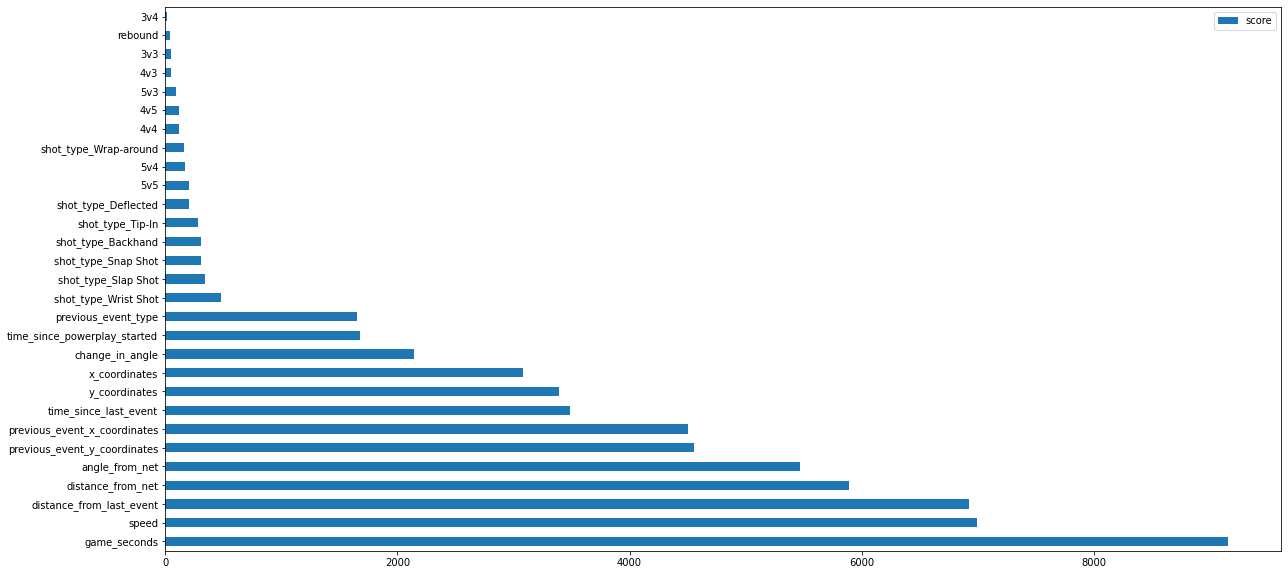

In [152]:
feature_important = model_2_cw.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

viz = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
plt = viz.nlargest(40, columns="score").plot(kind='barh', figsize = (20,10)) ## plot top 40 features
plt.figure.savefig("Q5_feature_importance.png")

In [65]:
experiment_3.log_image("Q5_feature_importance.png")

{'web': 'https://www.comet.ml/api/image/download?imageId=9c8661f8425346f1bded630d06ccdaf7&experimentKey=5d20421b4b2f44ec89581e3b7d11e5db',
 'api': 'https://www.comet.ml/api/rest/v1/image/get-image?imageId=9c8661f8425346f1bded630d06ccdaf7&experimentKey=5d20421b4b2f44ec89581e3b7d11e5db',
 'imageId': '9c8661f8425346f1bded630d06ccdaf7'}

In [ ]:
## To also visualize the importance of class weight and stratifying the data, 
# the difference between the feature importance graphs could be helpful(#BLOG)
explainer_2 = shap.Explainer(model_2_cw)
shap_values_2 = explainer_2(X_train_2)

shap.summary_plot(shap_values_2, X_train_2)

### Applying Recursive Feature Elimination

In [67]:
#adapted from https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/
from tqdm import tqdm
from sklearn.feature_selection import SelectFromModel
#
thresholds = np.sort(model_2_cw.feature_importances_)
for thresh in tqdm(thresholds):
    # select features using threshold
    selection = SelectFromModel(model_2_cw, threshold=thresh, prefit=True)
    select_X_train_2 = selection.transform(X_train_2)
    # train model
    selection_model = XGBClassifier(**hp_params)
    selection_model.fit(select_X_train_2, y_train_2, sample_weight=classes_weights)
    # eval model
    select_X_valid_2 = selection.transform(X_valid_2)
    y_pred = selection_model.predict(select_X_valid_2)
    predictions = [round(value) for value in y_pred]
    accuracy = accuracy_score(y_valid_2, predictions)
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train_2.shape[1], accuracy*100.0))

  0%|          | 0/31 [00:00<?, ?it/s]The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  3%|▎         | 1/31 [03:30<1:45:12, 210.41s/it]

Thresh=0.000, n=31, Accuracy: 86.71%


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  6%|▋         | 2/31 [06:59<1:41:17, 209.56s/it]

Thresh=0.000, n=31, Accuracy: 86.71%


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
 10%|▉         | 3/31 [10:19<1:35:41, 205.06s/it]

Thresh=0.012, n=29, Accuracy: 86.71%


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
 13%|█▎        | 4/31 [13:41<1:31:49, 204.06s/it]

Thresh=0.020, n=28, Accuracy: 86.87%


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
 16%|█▌        | 5/31 [16:52<1:26:20, 199.23s/it]

Thresh=0.022, n=27, Accuracy: 86.43%


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
 19%|█▉        | 6/31 [19:54<1:20:37, 193.51s/it]

Thresh=0.023, n=26, Accuracy: 86.32%


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
 23%|██▎       | 7/31 [22:46<1:14:33, 186.38s/it]

Thresh=0.023, n=25, Accuracy: 85.76%


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
 26%|██▌       | 8/31 [25:29<1:08:32, 178.82s/it]

Thresh=0.023, n=24, Accuracy: 84.94%


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
 29%|██▉       | 9/31 [28:08<1:03:19, 172.72s/it]

Thresh=0.023, n=23, Accuracy: 84.94%


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
 32%|███▏      | 10/31 [30:38<57:57, 165.61s/it] 

Thresh=0.024, n=22, Accuracy: 85.19%


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
 35%|███▌      | 11/31 [32:57<52:32, 157.63s/it]

Thresh=0.024, n=21, Accuracy: 84.59%


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
 39%|███▊      | 12/31 [35:06<47:06, 148.78s/it]

Thresh=0.025, n=20, Accuracy: 83.42%


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
 42%|████▏     | 13/31 [37:12<42:36, 142.04s/it]

Thresh=0.026, n=19, Accuracy: 82.95%


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
 45%|████▌     | 14/31 [39:05<37:45, 133.24s/it]

Thresh=0.026, n=18, Accuracy: 82.68%


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
 48%|████▊     | 15/31 [40:51<33:21, 125.09s/it]

Thresh=0.027, n=17, Accuracy: 80.69%


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
 52%|█████▏    | 16/31 [42:33<29:29, 117.95s/it]

Thresh=0.028, n=16, Accuracy: 80.86%


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
 55%|█████▍    | 17/31 [44:05<25:42, 110.17s/it]

Thresh=0.028, n=15, Accuracy: 74.64%


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
 58%|█████▊    | 18/31 [45:31<22:20, 103.11s/it]

Thresh=0.029, n=14, Accuracy: 74.31%


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
 61%|██████▏   | 19/31 [46:46<18:53, 94.46s/it] 

Thresh=0.029, n=13, Accuracy: 71.32%


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
 71%|███████   | 22/31 [50:00<11:09, 74.42s/it]

Thresh=0.035, n=10, Accuracy: 70.53%


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
 74%|███████▍  | 23/31 [50:53<09:01, 67.75s/it]

Thresh=0.035, n=9, Accuracy: 64.85%


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
 77%|███████▋  | 24/31 [51:41<07:13, 61.91s/it]

Thresh=0.036, n=8, Accuracy: 64.90%


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
 81%|████████  | 25/31 [52:25<05:40, 56.69s/it]

Thresh=0.043, n=7, Accuracy: 64.63%


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
 84%|████████▍ | 26/31 [53:05<04:17, 51.59s/it]

Thresh=0.047, n=6, Accuracy: 64.31%


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
 87%|████████▋ | 27/31 [53:42<03:08, 47.20s/it]

Thresh=0.047, n=5, Accuracy: 64.48%


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
 90%|█████████ | 28/31 [54:14<02:07, 42.56s/it]

Thresh=0.052, n=4, Accuracy: 64.27%


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
 94%|█████████▎| 29/31 [54:42<01:16, 38.36s/it]

Thresh=0.058, n=3, Accuracy: 63.72%


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
 97%|█████████▋| 30/31 [54:45<00:27, 27.67s/it]

Thresh=0.067, n=2, Accuracy: 80.55%


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
100%|██████████| 31/31 [54:47<00:00, 106.04s/it]

Thresh=0.097, n=1, Accuracy: 90.62%


### Retrain based on the optimal accuracy value

In [153]:
## second best thresh value is prioritzed here, as the best value allows only one feature which can make the model biased
thresh = 0.020
selection = SelectFromModel(model_2_cw, threshold=thresh, prefit=True)
select_X_train_2 = selection.transform(X_train_2)

selection_model = XGBClassifier(**param_list[3])
selection_model.fit(select_X_train_2, y_train_2, sample_weight=classes_weights)


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=2, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=30, min_child_weight=0.25, missing=nan,
              monotone_constraints='()', n_estimators=300, n_jobs=2,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [154]:
cols = selection.get_support(indices=True)
transformed_X_train_2 = X_train_2.iloc[:,cols]
transformed_X_valid_2 = X_valid_2.iloc[:,cols]

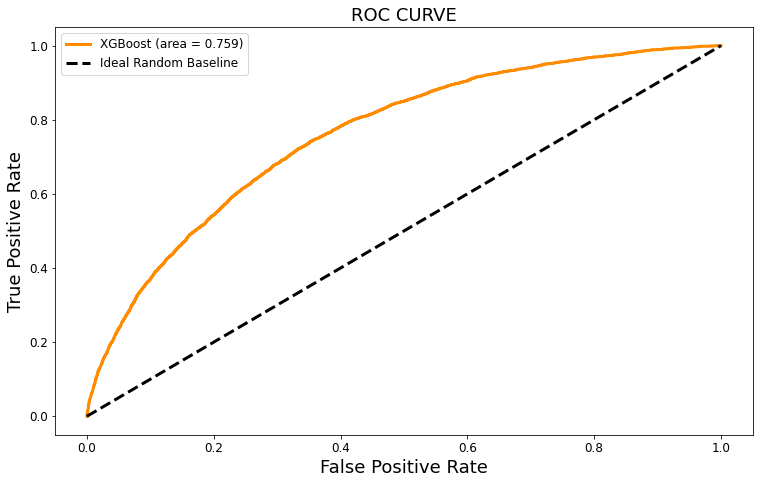

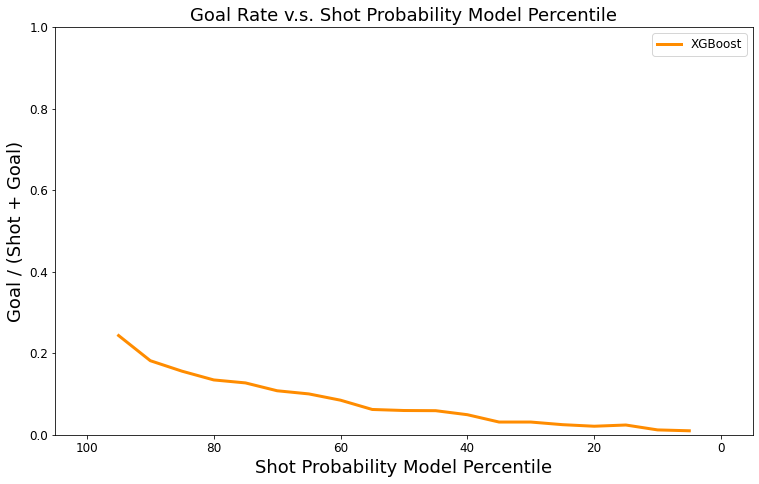

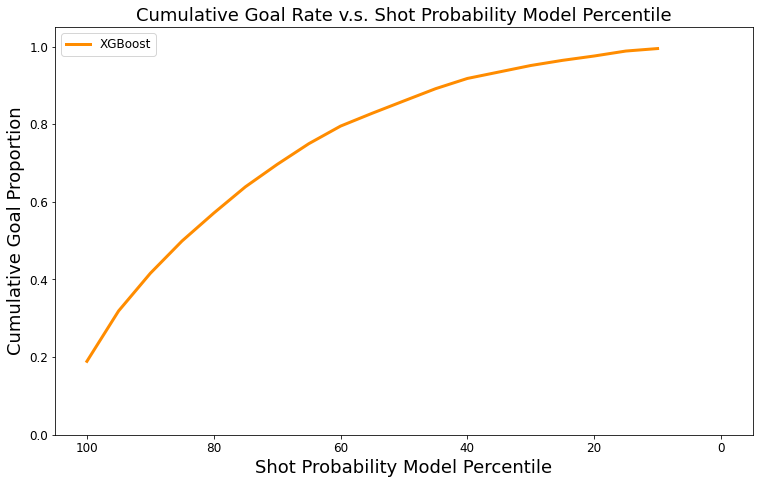

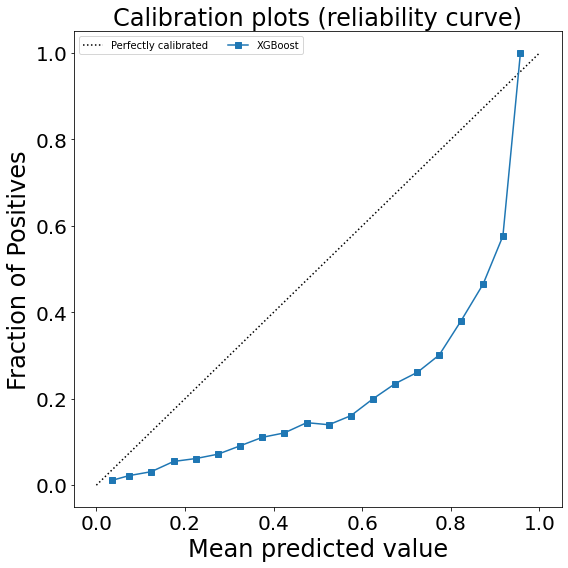

In [157]:
#### USAGE ####
model_name_7 = "3_xgboost_fs"
perf_eval = Performance_Eval(selection_model,model_name_7, transformed_X_train_2, y_train_2, transformed_X_valid_2, y_valid_2, question_no)
roc = perf_eval.get_roc_auc_plot()
grp= perf_eval.get_goal_rate_plot()
crp = perf_eval.get_cum_rate_plot()
cr = perf_eval.get_calibration_plot()

### Log Model and Plots

In [158]:

experiment_3.log_figure(figure = roc, figure_name=f'Q{question_no}_{model_name_7}_ROC_curve.png')
experiment_3.log_figure(figure = grp, figure_name=f'Q{question_no}_{model_name_7}_Goal_Rate.png')
experiment_3.log_figure(figure = crp, figure_name=f'Q{question_no}_{model_name_7}_Cum_Goal.png')
experiment_3.log_figure(figure = cr, figure_name=f'Q{question_no}_{model_name_7}_Calibration_Curve.png')

{'web': 'https://www.comet.ml/api/image/download?imageId=934468c83ccd4414af828b5aa9fde9f0&experimentKey=5d20421b4b2f44ec89581e3b7d11e5db',
 'api': 'https://www.comet.ml/api/rest/v1/image/get-image?imageId=934468c83ccd4414af828b5aa9fde9f0&experimentKey=5d20421b4b2f44ec89581e3b7d11e5db',
 'imageId': '934468c83ccd4414af828b5aa9fde9f0'}

In [160]:
pickle.dump(selection_model, open("XGBoost_feature_selection_model_v2.pickle", 'wb'))
t = pickle.load(open("XGBoost_feature_selection_model_v2.pickle", 'rb'))

experiment_3.log_model(name = "XGBoost_feature_selection_model_v2", file_or_folder = "XGBoost_feature_selection_model_v2.pickle")

{'web': 'https://www.comet.ml/api/asset/download?assetId=a0d3ccfb0a464239b96c7f00d8aca6a6&experimentKey=5d20421b4b2f44ec89581e3b7d11e5db',
 'api': 'https://www.comet.ml/api/rest/v2/experiment/asset/get-asset?assetId=a0d3ccfb0a464239b96c7f00d8aca6a6&experimentKey=5d20421b4b2f44ec89581e3b7d11e5db',
 'assetId': 'a0d3ccfb0a464239b96c7f00d8aca6a6'}

In [161]:
experiment_3.url

'https://www.comet.ml/kleitoun/milestone-2/5d20421b4b2f44ec89581e3b7d11e5db'

In [162]:
y_pred_proba_cw = selection_model.predict_proba(transformed_X_valid_2)[:,1]
roc_auc =  roc_auc_score(y_valid_2,y_pred_proba_cw)
y_pred_cw = selection_model.predict(transformed_X_valid_2)
accuracy =  accuracy_score(y_valid_2, y_pred_cw)
report = classification_report(y_valid_2, y_pred_cw, output_dict=True)

print(roc_auc, accuracy)
report

#result: 0.7593543260298987 0.7885262413475345

0.7593543260298987 0.7885262413475345


{'0': {'precision': 0.9422662410302584,
  'recall': 0.8166812495566014,
  'f1-score': 0.874990498872533,
  'support': 42287},
 '1': {'precision': 0.22572912504994008,
  'recall': 0.5164533820840951,
  'f1-score': 0.3141506811231582,
  'support': 4376},
 'accuracy': 0.7885262413475345,
 'macro avg': {'precision': 0.5839976830400992,
  'recall': 0.6665673158203482,
  'f1-score': 0.5945705899978456,
  'support': 46663},
 'weighted avg': {'precision': 0.875070252355508,
  'recall': 0.7885262413475345,
  'f1-score': 0.822395615507313,
  'support': 46663}}

In [163]:
metrics = {
    "roc_auc": roc_auc,
    "accuracy": accuracy,
    "classification report": report
}

In [164]:
experiment_3.log_metrics(metrics)

COMET WARNING: Cannot safely convert {'0': {'precision': 0.9422662410302584, 'recall': 0.8166812495566014, 'f1-score': 0.874990498872533, 'support': 42287}, '1': {'precision': 0.22572912504994008, 'recall': 0.5164533820840951, 'f1-score': 0.3141506811231582, 'support': 4376}, 'accuracy': 0.7885262413475345, 'macro avg': {'precision': 0.5839976830400992, 'recall': 0.6665673158203482, 'f1-score': 0.5945705899978456, 'support': 46663}, 'weighted avg': {'precision': 0.875070252355508, 'recall': 0.7885262413475345, 'f1-score': 0.822395615507313, 'support': 46663}} object to a scalar value, using its string representation for logging.


# Experiment 4 for improvement

# SMOTE

## Does not give much of an improvement

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
# define dataset

In [ ]:
X_2 = impute_df(X_2)

In [ ]:
model = XGBClassifier(n_estimators= 150, max_depth= 4, learning_rate= 0.2, subsample= 1.0, min_child_weight= 5, gamma= 5, colsample_bytree= 1.0)
over = SMOTE(sampling_strategy="auto")
under = RandomUnderSampler(sampling_strategy="auto")
steps = [('over', over), ('under', under), ('model', model)]
pipeline = Pipeline(steps=steps)
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(pipeline, X_train_2, y_train_2, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % np.mean(scores))

In [ ]:
from imblearn.over_sampling import ADASYN
from collections import Counter
# summarize class distribution
counter = Counter(y_2)
print(counter)
# transform the dataset
oversample = ADASYN()
X_train_smote, y_train_smote = oversample.fit_resample(X_2, y_2)
# summarize the new class distribution
counter = Counter(y_train_smote)
print(counter)